<a href="https://colab.research.google.com/github/kysolvik/waterbodies-smp/blob/main/waterbodies-smp/train/train_smp_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Training UNet Semantic Segmentation Model using Segmentation-Models Pytorch

 ### First, install and load required libraries

In [ ]:
!pip uninstall crcmod
!pip install --no-cache-dir -U crcmod
!pip install segmentation-models-pytorch
!pip install pytorch-lightning==1.9
!pip install albumentations
!pip install torch
!pip install imagecodecs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for crcmod: filename=crcmod-1.7-cp310-cp310-linux_x86_64.whl size=31406 sha256=ce44037a6ec47a857e58e7b19894d174dde80cc2c5af81b5a41291f8b35a63ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-ekfmxpr9/wheels/85/4c/07/72215c529bd59d67e3dac29711d7aba1b692f543c808ba9e86
Successfully built crcmod
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=80ef7873a28a22501694ff69e2168f5f63832ee5a34fccc5f25064d6aece4dd5
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc468

In [ ]:
import os
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import albumentations as albu
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import PIL
import torch
import numpy as np
import segmentation_models_pytorch as smp
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import imagecodecs

In [ ]:
# Set random seed
pl.seed_everything(78, workers=True)

INFO:lightning_fabric.utilities.seed:Global seed set to 78


78

In [ ]:
CLASSES=['background', 'reservatorios', 'natural', 'hidrelectrica', 'mineracao']

### Download training data

In [ ]:
# Load mean and std for scaling
!gsutil cp 'gs://res-id/cnn/training/prepped_data.zip' .
!mkdir -p ./data
!unzip ./prepped_data.zip -d ./data

Copying gs://res-id/cnn/training/prepped_data.zip...
- [1 files][140.8 MiB/140.8 MiB]                                                
Operation completed over 1 objects/140.8 MiB.                                    
Archive:  ./prepped_data.zip
   creating: ./data/ann_dir/
   creating: ./data/img_dir/
  inflating: ./data/bands_min_max.npy  
  inflating: ./data/mean_std.npy     
   creating: ./data/img_dir/test/
   creating: ./data/img_dir/train/
   creating: ./data/img_dir/val/
  inflating: ./data/img_dir/val/eg_tile_396.tif  
  inflating: ./data/img_dir/val/eg_tile_237.tif  
  inflating: ./data/img_dir/val/eg_tile_171.tif  
  inflating: ./data/img_dir/val/eg_tile_384.tif  
  inflating: ./data/img_dir/val/eg_tile_58.tif  
  inflating: ./data/img_dir/val/eg_tile_485.tif  
  inflating: ./data/img_dir/val/eg_tile_452.tif  
  inflating: ./data/img_dir/val/eg_tile_132.tif  
  inflating: ./data/img_dir/val/eg_tile_112.tif  
  inflating: ./data/img_dir/val/eg_tile_387.tif  
  inflating: ./dat

In [ ]:
x_train_dir = './data/img_dir/train/'
y_train_dir = './data/ann_dir/train'

x_valid_dir = './data/img_dir/val'
y_valid_dir = './data/ann_dir/val'



In [ ]:
mean_std = np.load('./data/mean_std.npy')

### Set up Pytorch Dataset, including augmentation and preprocessing

In [ ]:
# Some helper functions

def get_training_augmentation():
    """Random combination of flipping, 90 deg rotation, and scaling in"""
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomRotate90(p=1.0),
        albu.ShiftScaleRotate(scale_limit=(0, 0.25), rotate_limit=0, shift_limit=0.0, p=0.5, border_mode=0),
    ]
    return albu.Compose(train_transform, is_check_shapes=False)


def to_tensor(x, **kwargs):
    """Helper function to rearrange dimensions to match Torch Tensor expectations

    Before: xdim, ydim, bands
    After: bands, xdim, ydim
    """
    return torch.Tensor(x.transpose(2, 0, 1).astype('float32'))

def to_tensor_int(x, **kwargs):
    """Helper function to rearrange dimensions to match Torch Tensor expectations

    Before: xdim, ydim, bands
    After: bands, xdim, ydim
    """
    return torch.Tensor(x.transpose(2, 0, 1)).long()

def get_preprocessing():
    """Construct preprocessing transform

    In this case, all it does is rearrange dims (see to_tensor above)
    """

    _transform = [
        albu.Lambda(image=to_tensor, mask=to_tensor_int),
    ]
    return albu.Compose(_transform, is_check_shapes=False)

def normalize_image(ar, mean_std):
    """Scale to mean == 0, std == 1"""
    return (ar - mean_std[0])/mean_std[1]


In [ ]:
class Dataset(BaseDataset):
    """Dataset Object Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """


    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
            mean_std = None
    ):
        self.ids = os.listdir(images_dir)
        self.ids.sort()
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.classes = classes
        self.class_values = [self.classes.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.mean_std = mean_std

    def __getitem__(self, i):

        # read data
        image = io.imread(self.images_fps[i])
        mask = io.imread(self.masks_fps[i])

        # extract certain classes from mask
        if len(self.classes) == 2:
          # Binary
          masks = [(mask == 1)]
        else:
          # Multi-class
          masks = [mask]#[(mask == v) for v in self.class_values]

        mask = np.stack(masks, axis=-1).astype('float')

        if self.mean_std is not None:
            image = normalize_image(image, self.mean_std)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=(image.astype(np.float32)), mask=mask)
            image, mask = sample['image'], sample['mask']
            # if np.random.randint(0,1):
            gauss_scale = np.random.uniform(0, 0.1)
            image = image + np.random.normal(scale=gauss_scale, size=image.shape)


        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']


        #Convert to PIL
        return {'image':image, 'mask':mask}

    def __len__(self):
        return len(self.ids)

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    bands_to_view=[2, 1, 0]
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i ==0:
          plt.imshow(image[:,:, bands_to_view])
          print('Final mean', image.mean())
        else:
          plt.imshow(image, vmax=len(CLASSES))

    plt.show()

Final mean 60.17842468261719


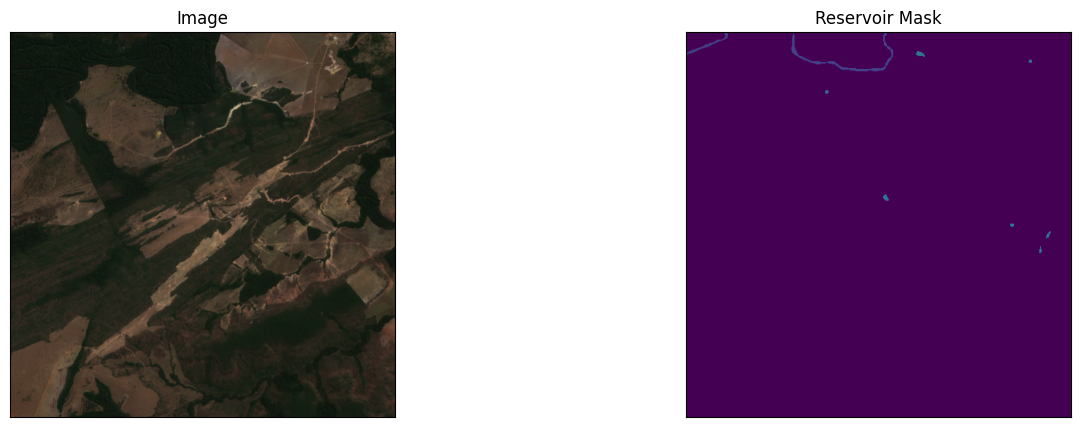

In [ ]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES,
                  # augmentation=get_training_augmentation(),
                  # mean_std=mean_std,
)

batch = dataset[5] # get some sample
visualize(
    image=batch['image'],
    reservoir_mask=batch['mask']
    )

### Define Unet Model

In [ ]:
class ResModel(pl.LightningModule):

    def __init__(self, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.Unet(encoder_name=encoder_name,
                               in_channels=in_channels,
                               classes=out_classes,
                               aux_params=dict(classes=out_classes)
        )

        # DiceLoss generally does a good job for image segmentation
        self.loss_fn = smp.losses.DiceLoss(mode='multiclass', from_logits=False)

        # Input images are 640x640, masks are 500x500. So we apply a crop to only look at the middle
        self.crop_transform = torchvision.transforms.CenterCrop(500)

    def forward(self, image):
        # normalize image here
        mask = self.model(image)[0]
        return self.crop_transform(mask)

    def shared_step(self, batch, stage):

        ### Prep image ###
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0


        ### Prep mask ###
        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        assert mask.ndim == 4


        ### Run forward prediction ###
        logits_mask = self.forward(image)
        pred_mask = logits_mask.softmax(dim=1)



        ### Calculate loss and other metrics ###
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(pred_mask, mask)

        mask_onehot = torch.nn.functional.one_hot(mask.long(), pred_mask.shape[1])[:,0].permute(0, 3, 1, 2)
        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(),
            mask_onehot,
            mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # Aggregate metrics
        loss = torch.mean(torch.tensor([x['loss'] for x in outputs]))
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # Calculate IoU
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_iou": dataset_iou,
            f"{stage}_loss": loss,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):

        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch['image']).softmax(dim=1)

    def configure_optimizers(self):
        # Learning rate, weight decay, and learning rate scheduler (decreasers by x0.9 per epoch)
        # These all may need to be tweaked in detail
        optim = torch.optim.Adam(self.parameters(), lr=0.0001, weight_decay=1e-5)
        return [optim], [torch.optim.lr_scheduler.ExponentialLR(optim, 0.9)]

In [ ]:
# Here we define the model. We use a resnet34 encoder "backbone", which is a pretty simple one that does a good job
model = ResModel(encoder_name="resnet34", in_channels=4, out_classes=5)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 97.6MB/s]


### Setup and run training

In [ ]:
# Stop training when validation loss doesn't improve for 5 epochs
early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(monitor="valid_loss", mode='min', min_delta=0.00, patience=10)
# Save best validation dataset IoU model only
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath="/content/", save_top_k=1, monitor="valid_loss", mode='min')
# Keep track of training and validation IoU while training
logger = pl.loggers.CSVLogger("/content/logs/", name="training_metrics")

In [ ]:
# Training dataset. Note that it gets augmentation
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    preprocessing=get_preprocessing(),
    augmentation=get_training_augmentation(),
    classes=CLASSES,
    mean_std=mean_std,
)
# Validation dataset, no augmentation
valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    preprocessing=get_preprocessing(),
    classes=CLASSES,
    mean_std=mean_std,
)

# DataLoaders that the trainer will use for loading datasets in batches
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=2)

In [ ]:
# Define trainer. In this case, we're using a GPU to accelerate training
# To attach a GPU in Colab, click: "Runtime -> Change runtime type -> T4 GPU -> Save"
trainer = pl.Trainer(
    gpus=1,
    max_epochs=50,
    callbacks=[early_stop_callback, checkpoint_callback],
    deterministic=True,
    logger=logger
)

# Fit
trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name 

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


### View some example results

In [ ]:
# Let's reload the model with the best results
# Change the 'checkpoint_path' to match the .ckpt file that was saved in your files (pane on left)
checkpoint_path = './epoch=46-step=705.ckpt'
pred_model = ResModel.load_from_checkpoint(checkpoint_path, in_channels=4, out_classes=5, encoder_name='resnet34')

In [ ]:
preds =  np.vstack(trainer.predict(pred_model, valid_loader))
preds_maxclass = np.argmax(preds, axis=1)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 15it [00:00, ?it/s]

In [ ]:
# Validation dataset for visualization
valid_dataset_noscaling = Dataset(
    x_valid_dir,
    y_valid_dir,
    classes=CLASSES,
)

In [ ]:
def vis_image_mask_pred(predictions, ds, i):
    pred_mask = np.expand_dims(predictions[i], 2)
    true_mask = np.array(ds[i]['mask'])
    # Multiply by 1.5 to brighten the image
    true_image_rgb = (1.5*np.array(ds[i]['image'][70:570, 70:570, [2, 1, 0]])).astype(int)
    og_rows, og_cols = true_mask.shape[0], true_mask.shape[1]
    # Display image, predicted mask, and acDr. Thoralf Meyertual masks side by side
    fig, axs = plt.subplots(1, 3, figsize=(15, 12))
    axs[0].imshow(true_image_rgb)
    axs[1].imshow(true_mask,  vmax=len(CLASSES))
    axs[2].imshow(pred_mask, vmax=len(CLASSES))
    plt.show()

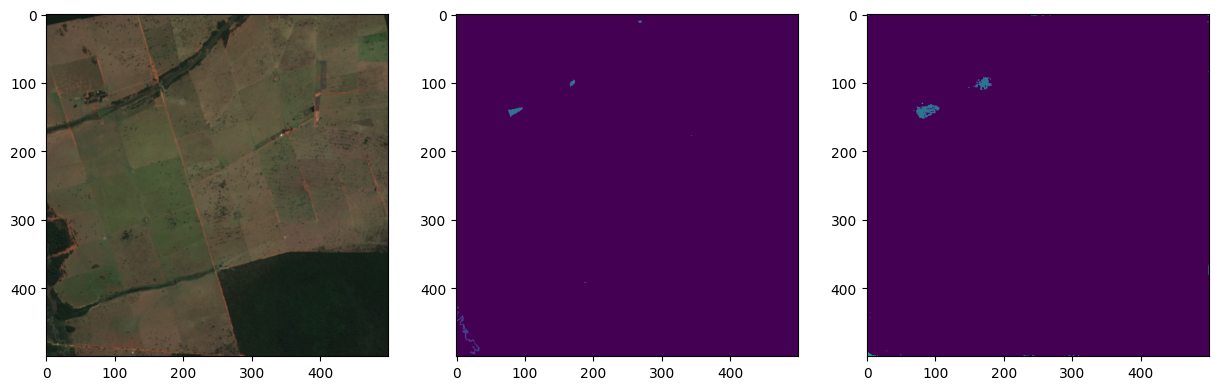

In [ ]:
vis_image_mask_pred(preds_maxclass, valid_dataset_noscaling, 1)

All done! After training, download the "ckpt" file corresponding to the best model

It should be appear in the sidebar:

Then you're done! Unless you want to try training again, you can delete the runtime by clicking "Runtime -> Disconnect and delete runtime"

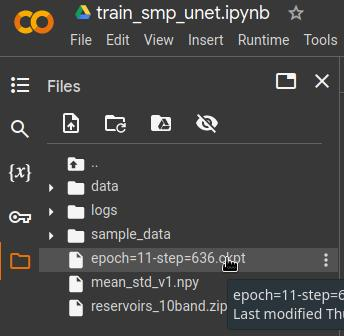